This notebook calculates the distance to the nearest 10^5.5 and 10^ 6.5 Msun molecular cloud from the locations of each of the SNe located within 150pc maps.

In [1]:
#import packages and initialize settings
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.io import ascii
from astropy.table import Table
from progressbar import progressbar
from astropy.wcs import WCS
from reproject import reproject_interp

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
from FindNearestMC import nearestMCMethod

In [2]:
# Unpack master table to get SNe information
database = Table.read('../Data/3.SNe+GalData.csv', format = "csv")

database[0:1]

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,NatRes,NatInt,pc60Int,pc90Int,pc120Int,pc150Int,pc500Int,pc750Int,pc1000Int,NatErr,pc60Err,pc90Err,pc120Err,pc150Err,pc500Err,pc750Err,pc1000Err,NatEW,pc60EW,pc90EW,pc120EW,pc150EW,pc500EW,pc750EW,pc1000EW,NatSNR,pc60SNR,pc90SNR,pc120SNR,pc150SNR,pc500SNR,pc750SNR,pc1000SNR,alphaCO,pc60mgsd,pc90mgsd,pc120mgsd,pc150mgsd,pc500mgsd,pc750mgsd,pc1000mgsd,pc60mgsdErr,pc90mgsdErr,pc120mgsdErr,pc150mgsdErr,pc500mgsdErr,pc750mgsdErr,pc1000mgsdErr,SN_percentile
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str74,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str13
ngc1566,ASASSN-14ha,II,65.0059,-54.9381,258.9038295074317,423.1062029210927,68.05383,1.8849889,12.188041,0.0003484111476313,65.00159,-54.93801,17.69,214.7,29.5,216.83093,12m+7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1566/ngc1566_12m+7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1566/ngc1566_12m+7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/NGC1566_alphaCO21_Sun+20.fits,107.5715044627487,68.0538330078125,nan,nan,65.95396423339844,61.926334381103516,27.371265411376953,26.06928253173828,27.377416610717773,1.8849889039993286,nan,nan,1.6742128133773804,1.3591481447219849,0.5764862298965454,0.3906446397304535,0.27018043398857117,12.188040733337402,nan,nan,12.932862281799316,13.762829780578613,19.730430603027344,29.85703468322754,43.81895446777344,36.10304170142571,nan,nan,39.39401473122755,45.56260818335635,47.47947824580116,66.73400804814882,101.33012300911419,4.304510126195559,nan,nan,283.8995069054033,266.5625334216323,117.81988913005836,112.21549064052044,117.84636702990916,nan,nan,7.20666600858929,5.850466951955691,2.481490814201981,1.6815338074637531,1.1629944140037154,0.98


[None, array([0.01364605]), array([0.55655997]), array([0.01321117]), array([0.00491407]), array([0.01275901]), array([0.1489542]), array([0.19534568]), array([0.35979567]), array([0.01287783]), array([0.01284268]), array([1.22508167]), array([0.01592836]), array([0.00761477]), array([0.00716833]), array([0.00421925]), None, array([0.07117317]), array([0.00321098]), array([0.0076644]), array([0.58246467]), array([0.01154423]), array([0.00611075]), array([0.00733605]), array([0.01245564]), array([0.01044295]), array([0.0040826]), array([0.00808865]), array([0.01097162]), array([0.02066585]), array([0.08586097]), array([0.03508382]), array([0.02765949]), array([0.0155404]), array([0.03955008]), array([0.02026862]), array([0.2480944]), array([0.10081377]), array([0.0106565]), array([0.00660132]), array([0.06650442]), array([0.01621761]), array([0.03209613]), array([0.38714994]), array([0.00946752]), array([0.29470551]), array([0.10821323]), array([0.37426845]), None, None, array([5800.10100662]), array([0.01400941]), array([0.01271513]), array([0.00453499]), array([0.00497956]), array([0.00238751]), array([0.05432539]), array([0.00023186]), array([0.0098961]), array([0.01070017]), array([0.99123115])]

[0.03220571, 0.03057009, 0.31916941, 0.75480179, 0.02805144]

In [3]:
database.sort("galaxy")
gal_group = database.group_by("galaxy")
print(len(gal_group))
print(gal_group)

59
 galaxy   SN_name    SN_type    ...    pc1000mgsdErr    SN_percentile
-------- --------- ------------ ... ------------------- -------------
circinus  SN1996cr           II ...  0.8091620438290308          0.98
 ngc0253   SN1940E            I ...  0.4121687199618783          0.99
 ngc0628  SN2013ej           II ... 0.49282741849621114 non-detection
 ngc1087   SN1995V           II ...  0.7219935606169763           0.9
 ngc1097  SN1999eu           II ...   0.357538346031736 non-detection
 ngc1097  SN1992bd           II ...  0.6440294703398377          0.99
 ngc1365  SN2012fr           Ia ...  0.8226942793375035 non-detection
 ngc1365  SN2001du           II ...  1.2412372438845123 non-detection
 ngc1365   SN1983V           Ic ...  0.7854228241047587          0.24
 ngc1433   SN1985P           II ... 0.31674932645786724 non-detection
     ...       ...          ... ...                 ...           ...
 ngc4945  SN2011ja           II ...  0.3388542719185352          0.93
 ngc5128 SN2016ad

In [4]:
centerCoords = [(database["orient_ra"][i], database["orient_dec"][i]) for i in range(len(database))]    
SNe, SNra, SNdec  = database["SN_name"], database["SN_ra"], database["SN_dec"]
SNra  = np.array(SNra)
SNdec = np.array(SNdec)
massCutA = 10**5.5
massCutB = 10**6.5
gal_group.groups.indices
print(gal_group["galaxy"])

 galaxy 
--------
circinus
 ngc0253
 ngc0628
 ngc1087
 ngc1097
 ngc1097
 ngc1365
 ngc1365
 ngc1365
 ngc1433
     ...
 ngc4945
 ngc5128
 ngc5128
 ngc5236
 ngc5236
 ngc5236
 ngc5236
 ngc5236
 ngc5530
 ngc6744
 ngc7793
Length = 59 rows


In [5]:
# remove duplicate galaxies, grouping SNe together in their own lists.

SNr, SNd, SNa = [],[],[]
gala, imgs, errs, alco, cocs, pans, incl, gdis, SNrs, SNdc, SNea = [],[],[],[],[],[],[],[],[],[],[]

for i in range(len(database)):
    gal = database["galaxy"][i]
    img = database["ImageFile150"][i]
    ers = database["ErrFile150"][i]
    aco = "../Data/MassMaps/" + gal + "_Mass.fits"
    ccs = centerCoords[i]
    pas = database["orient_posang"][i]
    inc = database["orient_incl"][i]
    gds = database["dist"][i]
    SNr.append(SNra[i])
    SNd.append(SNdec[i])
    SNa.append(SNe[i])
    
    if (i+1) in gal_group.groups.indices:
        print(i+1, gal, aco, SNr, SNd, SNa, ccs)
        gala.append(gal)
        imgs.append(img)
        errs.append(ers)
        alco.append(aco)
        cocs.append(ccs)
        pans.append(pas)
        incl.append(inc)
        gdis.append(gds)
        SNrs.append(SNr)
        SNdc.append(SNd)
        SNea.append(SNa) 
        SNr, SNd, SNa = [],[],[]
    else: pass

1 circinus ../Data/MassMaps/circinus_Mass.fits [213.2918] [-65.3457] ['SN1996cr'] (213.29124, -65.33915)
2 ngc0253 ../Data/MassMaps/ngc0253_Mass.fits [11.8783] [-25.2934] ['SN1940E'] (11.887966, -25.288443)
3 ngc0628 ../Data/MassMaps/ngc0628_Mass.fits [24.2007] [15.7586] ['SN2013ej'] (24.173855, 15.783643)
4 ngc1087 ../Data/MassMaps/ngc1087_Mass.fits [41.6115] [-0.4988] ['SN1995V'] (41.60492, -0.498717)
6 ngc1097 ../Data/MassMaps/ngc1097_Mass.fits [41.5866, 41.5792] [-30.3184, -30.2756] ['SN1999eu', 'SN1992bd'] (41.578957, -30.274675)
9 ngc1365 ../Data/MassMaps/ngc1365_Mass.fits [53.4006, 53.3713, 53.3819] [-36.1268, -36.1421, -36.1486] ['SN2012fr', 'SN2001du', 'SN1983V'] (53.40152, -36.140404)
10 ngc1433 ../Data/MassMaps/ngc1433_Mass.fits [55.5264] [-47.21] ['SN1985P'] (55.506195, -47.221943)
11 ngc1511 ../Data/MassMaps/ngc1511_Mass.fits [59.9373] [-67.6374] ['SN1935C'] (59.90246, -67.63393)
15 ngc1559 ../Data/MassMaps/ngc1559_Mass.fits [64.4167, 64.4077, 64.374, 64.3981] [-62.7776, -

In [6]:
#for i in range(len(gal_group.groups.indices)-1):
print(gala[3], imgs[3], alco[3])
print(gdis)
print(len(gala))
print()

ngc1087 /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1087/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits ../Data/MassMaps/ngc1087_Mass.fits
[4.2, 3.7, 9.84, 15.85, 13.58, 19.57, 18.63, 15.28, 19.44, 17.69, 11.7, 23.15, 14.06, 10.86, 11.32, 13.1, 16.99, 15.21, 16.2, 15.1, 14.86, 16.25, 3.47, 3.69, 4.89, 12.27, 9.39, 3.62]
28



In [7]:

nearest55, nearest65 = [],[]
for i in range(len(gala)):
    if incl[i] == 90.0:
        incl[i]=80.0
    near55, near65 = nearestMCMethod(gala[i], imgs[i], errs[i], alco[i], cocs[i], pans[i], incl[i], gdis[i], SNrs[i], SNdc[i], SNea[i])
    nearest55.append(near55)
    nearest65.append(near65)

at Mass cutoff A for circinus
Pixels with Mass > 10**5.5 5804
Nearest 55 [32.20571075] circinus
Pixels with Mass > 10**6.5 1194
Nearest 65 [32.20571075] circinus
done with circinus  
at Mass cutoff A for ngc0253
Pixels with Mass > 10**5.5 36463
Nearest 55 [30.57009157] ngc0253
Pixels with Mass > 10**6.5 6123
Nearest 65 [30.57009157] ngc0253
done with ngc0253  
at Mass cutoff A for ngc0628
Pixels with Mass > 10**5.5 454353
Nearest 55 [97.87335683] ngc0628
Pixels with Mass > 10**6.5 1764
Nearest 65 [1914.40658196] ngc0628
done with ngc0628  
at Mass cutoff A for ngc1087
Pixels with Mass > 10**5.5 43276
Nearest 55 [13.6460475] ngc1087
Pixels with Mass > 10**6.5 1955
Nearest 65 [662.29661955] ngc1087
done with ngc1087  
at Mass cutoff A for ngc1097
Pixels with Mass > 10**5.5 42167
Nearest 55 [279.64329546  13.21116559] ngc1097
Pixels with Mass > 10**6.5 4990
Nearest 65 [6549.95976975   13.21116559] ngc1097
done with ngc1097  
at Mass cutoff A for ngc1365
Pixels with Mass > 10**5.5 69717
Ne

In [8]:
n55A = []
for i in range(len(nearest55)):
    if(type(nearest55[i])!= np.float64 and type(nearest55[i]) != float):
        for j in range(len(nearest55[i])):
            n55A.append(nearest55[i][j])
    else:
        n55A.append(nearest55[i])
#print(n55A)

n65A = []
for i in range(len(nearest65)):
    if(type(nearest65[i])!= np.float64 and type(nearest65[i]) != float):
        for j in range(len(nearest65[i])):
            n65A.append(nearest65[i][j])
    else:
        n65A.append(nearest65[i])
#print(n65A)

In [9]:
with open("../Data/NearestMCtoSNe.txt", "w") as textFile:
    print("# Nearest55MassArrayDistances, Nearest65MassArrayDistances (in pc)", file=textFile)
    print(n55A, n65A, file=textFile)

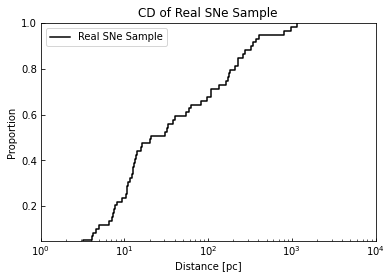

In [46]:
import seaborn as sns

fig = plt.figure(figsize = (6,4))
sns.ecdfplot(n55A,color = "black",  label="Real SNe Sample")
plt.xscale('log')
plt.legend(loc='best')
plt.ylim (0.05,1.0)
plt.xlim(1,10000)
# plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey', ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.title("CD of Real SNe Sample")
plt.xlabel("Distance [pc]")
fig.savefig("../Figures/RealSNeCDFs55.png", dpi=300)
plt.show()
plt.close()

In [28]:
modelResults = Table.read("../Data/AllModels.csv", format = 'csv')

def cleanModels(modelData):
    keep = np.where(np.isfinite(modelData))
    clean = modelData[keep]
    #clean = np.clip(clean, 1, None)
    clean = np.asarray(clean)
    return(clean)

n55m1 = cleanModels(modelResults["n55Mod1"])
n55m2 = cleanModels(modelResults["n55Mod2"])
n55m3 = cleanModels(modelResults["n55Mod3"])
n55m4 = np.concatenate((n55m2[0:1914],n55m3[1914:-1]))

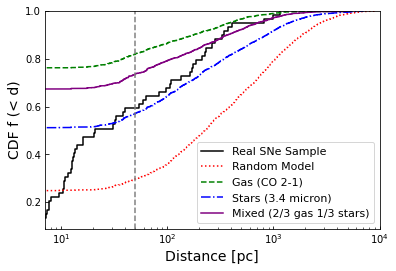

In [45]:

fig = plt.figure(figsize = (6,4))
sns.ecdfplot(n55A,color = "black",  label="Real SNe Sample")
sns.ecdfplot(n55m1, color = "red", ls = ":", label="Random Model")
sns.ecdfplot(n55m2, color = "green",ls = "--",  label="Gas (CO 2-1)")
sns.ecdfplot(n55m3, color = "blue",  ls = "-.",label="Stars (3.4 micron)")
sns.ecdfplot(n55m4, color = "purple", ls = "-", label="Mixed (2/3 gas 1/3 stars)")
plt.xscale('log')
plt.legend(loc='best', fontsize = 11)
plt.ylim (0.09,1.0)
plt.xlim(7,10000)
plt.axvline(x = 50,ymin = 0,ymax = 1, color='grey',
            ls = '--')
plt.tick_params(axis = "both", which = "both", direction = "in")
plt.xlabel("Distance [pc]", fontsize = 14)
plt.ylabel("CDF f (< d)", fontsize = 14)
fig.savefig("../Figures/ModelCDFs55.png", dpi=300)
plt.show()
plt.close()